# **Prediction of diagnosis of breast tumour**


---


### **Problem**

Breast cancer continues to be one of the most commonly diagnosed cancers in the United States. According to the Center for Disease Control, around 240,000 women and 2,100 men are diagnosed with breast cancer each year. Additionally, breast cancer claims the lives of 42,000 women and 500 men each year in the U.S.. This data is of interest because it investigates the predictive power of diagnostic tools used to distinguish between cancerous and non-cancerous tumors.

It is essential to note that not all tumors are cancerous; they can be classified as:

*   Benign (non-cancerous)
*   Pre-malignant (pre-cancerous)
*   Malignant (cancerous)

Diagnostic procedures such as MRI, mammogram, ultrasound, and biopsy are commonly employed to identify and assess breast cancer.

### **Expected Outcome**
The breast cancer diagnosis results in this dataset comes from breast fine needle aspiration (FNA) test (is a quick and simple procedure to perform, which removes some fluid or cells from a breast lesion or cyst (a lump, sore or swelling) with a fine needle similar to a blood sample needle).

Since this build a model that can classify a breast cancer tumor using two training classification:

* 1= Malignant (Cancerous) - Present
* 0= Benign (Not Cancerous) -Absent

# What's in the Data?
The data used in this project is sourced from diagnostic data collected by Dr. William H. Wolberg from the University of Wisconsin-Madison in 1990. Images of Fine Needle Aspirations (FNA) of 569 breast masses were analyzed across several characteristics. Each FNA sample contains cells, tissues, and flieds. Measurements of the nucleus within each cell can be collected to make a diagnosis. The aim of the data set was to utilize machine learning techniques to diagnose these masses as either malignant or benign based on ten features:


*   **radius**: distance between center to nucleus perimeter (mm)
*   **texture**: standard deviation of gray-scale values
*   **perimeter**: distance around the nucleus (mm)
*   **area**: distance across the surface of the nucleus (mm^2)
*   **smoothness**: local variation in radius lengths (mm)
*   **compactness**: perimeter^2/area - 1.0
*   **concavity**: size of the concave regions in the nucleus
*   **concave points**: number of concave regions in the nucleus
*   **symmetry**: how identical the nucleus is on either side
*   **fractal dimension**: coastline approximation - 1

The mean, standard error, and "worst" (largest) measure of each of the nine features were recorded in this data set. Each record has a unique id and diagnosis ('M'=malignant or 'B'= benign). In total, there are 32 columns.



### Initial setup

In [ ]:
!pip install pyspark

In [ ]:
#import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
from pyspark.sql.functions import skewness, when
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import numpy as np

In [ ]:
#load data
session=SparkSession.builder.appName("breastCancerAnalysis").master("local").getOrCreate()
data=session.read.csv("breast-cancer.csv", header=True, inferSchema=True)

### Inspecting the dataset

In [ ]:
data.show(2)

+------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|    id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+------+---------+-----------+------------+---------

In [ ]:
print("Number of rows: ", data.count())
print("Number of columns: ", len(data.columns))

Number of rows:  569
Number of columns:  32


In [ ]:
#checking data type of each column
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radi

In [ ]:
# The id column is unique and not useful, hence we can drop it
data = data.drop('id')

In [ ]:
# Check for missing values in each column
for column in data.columns:
    na_count = data.filter(col(column).isNull()).count()
    print(f"{column}: {na_count}")

diagnosis: 0
radius_mean: 0
texture_mean: 0
perimeter_mean: 0
area_mean: 0
smoothness_mean: 0
compactness_mean: 0
concavity_mean: 0
concave points_mean: 0
symmetry_mean: 0
fractal_dimension_mean: 0
radius_se: 0
texture_se: 0
perimeter_se: 0
area_se: 0
smoothness_se: 0
compactness_se: 0
concavity_se: 0
concave points_se: 0
symmetry_se: 0
fractal_dimension_se: 0
radius_worst: 0
texture_worst: 0
perimeter_worst: 0
area_worst: 0
smoothness_worst: 0
compactness_worst: 0
concavity_worst: 0
concave points_worst: 0
symmetry_worst: 0
fractal_dimension_worst: 0


In [ ]:
# Drop column _c32 as it has only NULL values
data = data.drop('_c32')

In [ ]:
# Check unique values in the 'diagnosis' column
unique_diagnosis_values = data.select("diagnosis").distinct().rdd.flatMap(lambda x: x).collect()
print("Unique values in 'diagnosis' column: ", unique_diagnosis_values)

Unique values in 'diagnosis' column:  ['B', 'M']


From the results above, diagnosis is a categorical variable, because it represents a fixed number of possible values (i.e, Malignant or Benign. We will convert them into numbers to make it useful for machine learning

### Now we have a good sense of the data. Next we can start our EDA to get a better understanding of the dataset which will give us useful knowledge for data preprocessing.

## **Exploratory Data Analysis**

Let us try to understand the data by performing descriptive statistics.

In [ ]:
summary_stats = data.describe()
# Show the summary statistics
summary_stats.show()

+-------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+
|summary|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_se|        concavity_se|   concave points_se|  

In [ ]:
numeric_columns = [col_name for col_name, col_type in data.dtypes if col_type in ["int", "double"]]
skewness_values = data.select([skewness(col(col_name)).alias(col_name) for col_name in numeric_columns])

# Show the skewness values
skewness_values.show()

+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+----------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+----------------+------------------+-----------------+--------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+---------------+--------------------+------------------+-----------------------+
|       radius_mean|      texture_mean|    perimeter_mean|         area_mean|    smoothness_mean|  compactness_mean|    concavity_mean|concave points_mean|     symmetry_mean|fractal_dimension_mean|        radius_se|        texture_se|      perimeter_se|          area_se|     smoothness_se|    compactness_se|    concavity_se| concave points_se|      symmetry_se|fractal_dimension_se|     radius_worst|     texture_worst| 

The skew result show a positive (right) or negative (left) skew. Values closer to zero show less skew. In this context, features having significant skewness may exhibit distinct groupings between malignant and benign cancer types. The mentioned features could be valuable in differentiating between the two cancer types due to their distribution characteristics.

The features radius_mean, perimeter_mean, area_mean, concavity_mean and concave_points_mean are useful in predicting cancer type due to the distinct grouping between malignant and benign cancer types in these features

In [ ]:
# grouping diagnosis by count
grouped_data = data.groupBy("diagnosis").agg(count("*").alias("# of observations"))

grouped_data.show()

+---------+-----------------+
|diagnosis|# of observations|
+---------+-----------------+
|        B|              357|
|        M|              212|
+---------+-----------------+



357 (B==0) observations indicates the absence of cancer cells and 212(M==1)show presence of cancer cells

### **Data Visualization**

One of the main goals of visualizing the data here is to observe which features are most helpful in predicting malignant or benign cancer. The other is to see general trends that may help us in model selection and hyper parameter selection.

In [ ]:
#Splitting data into smaller groups based on their designation of _mean, _se and _worst
data_mean = data.select(data.columns[1:11])
data_se =  data.select(data.columns[11:22])
data_worst =data.select(data.columns[23:])

<Figure size 1500x1000 with 0 Axes>

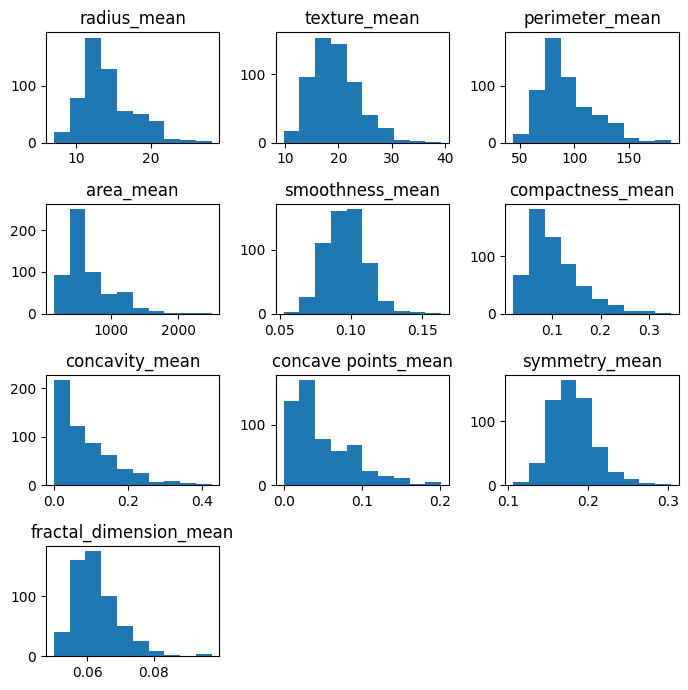

In [ ]:
hist_mean_pd = data_mean.select([col(c).alias(str(c)) for c in data_mean.columns]).toPandas()
# Plot histograms using matplotlib and seaborn
plt.figure(figsize=(15, 10))
hist_mean_pd.hist(bins=10, figsize=(7, 7), grid=False)
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

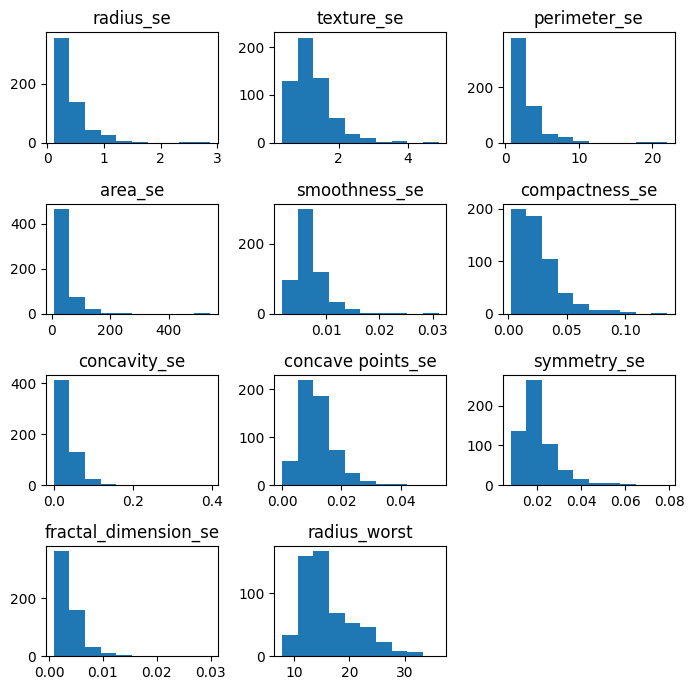

In [ ]:
hist_se = data_se.select([col(c).alias(str(c)) for c in data_se.columns]).toPandas()
# Plot histograms using matplotlib and seaborn
plt.figure(figsize=(15, 10))
hist_se.hist(bins=10, figsize=(7, 7), grid=False)
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

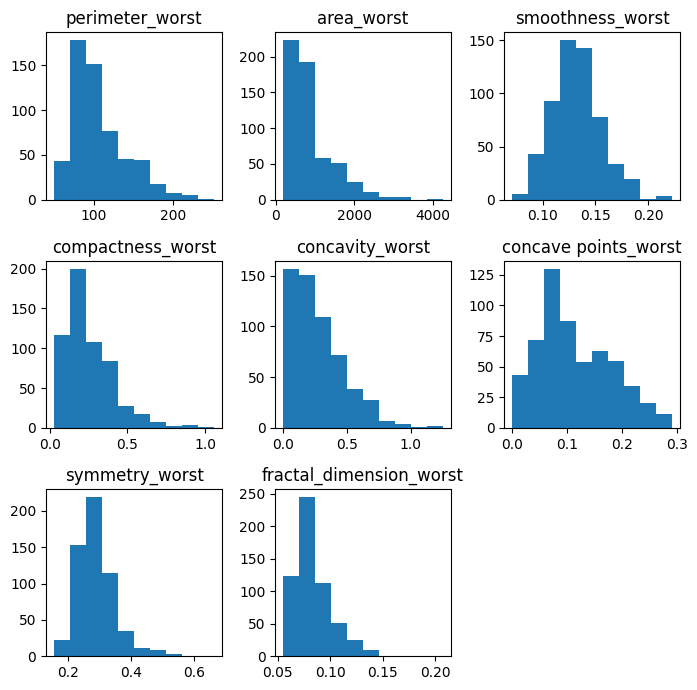

In [ ]:
hist_worst = data_worst.select([col(c).alias(str(c)) for c in data_worst.columns]).toPandas()
# Plot histograms using matplotlib and seaborn
plt.figure(figsize=(15, 10))
hist_worst.hist(bins=10, figsize=(7, 7), grid=False)
plt.tight_layout()
plt.show()

Features like concavity and concave points have an exponential distribution. This is useful for model selection as many machine learning techniques are sensitive to distribution where it assumes normal distribution. For our case, it may be useful to consider algorithms like Decision Trees, Random Forests, and Neural Networks or perform standardization of data.

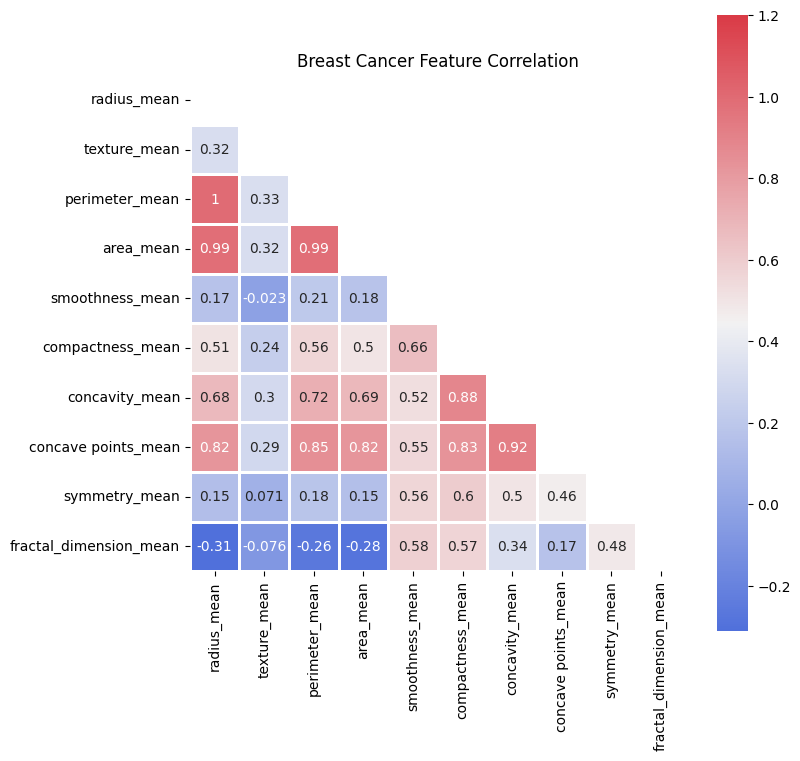

In [ ]:
#Correlation Matrix
# Select numeric columns for correlation
numeric_cols = [col_name for col_name, col_type in data_mean.dtypes if col_type in ["int", "double"]]
numeric_data = data_mean.select(numeric_cols)

# Assemble features into a single vector column
vec_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
numeric_data_assembled = vec_assembler.transform(numeric_data)

# Calculate the correlation matrix
corr_matrix = Correlation.corr(numeric_data_assembled, "features").collect()[0][0]

# Convert correlation matrix to Pandas DataFrame
corr_matrix_pd = pd.DataFrame(corr_matrix.toArray(), columns=numeric_cols, index=numeric_cols)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix_pd, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))
plt.title('Breast Cancer Feature Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_pd, vmax=1.2, square=True, cmap=cmap, mask=mask, annot=True, fmt='.2g', linewidths=2)

# Show the plot
plt.show()


### **Observations:**

1. Mean parameter values between 1 and 0.75 show a strong positive relationship. For instance, the mean area of the tissue nucleus is notably positively correlated with mean radius and perimeter.

2. Some parameters have moderate positive correlations(around 0.5 to 0.75), such as concavity with area and concavity with perimeter.

3. On the flip side, certain parameters, like fractal_dimension exhibit strong negative correlations with mean radius, texture, and perimeter.

### **Summary**
- Mean values of cell radius, perimeter, area, compactness, concavity and concave points can be used in classification of the cancer. Larger values of these parameters tends to show a correlation with malignant tumors.

- Mean values of texture, smoothness, symmetry or fractual dimension does not show a particular preference of one diagnosis over the other.


## **Data preparation**

The goal is to find the most predictive features in the data to increase the predictive power of our model.

We are going to achieve that by:
1. Assigning numerical values to categorical data
2. Normalizing the features (so that features on small scales do not dominate when fitting a model to the data).

In [ ]:
# Convert "diagnosis" column to binary indicator "diagnosis_int"
# "diagnosis_int" will be our target variable from this point
str_obj=StringIndexer(inputCols=["diagnosis"],outputCols=["new_diagnosis"], stringOrderType="alphabetAsc")
# Fit and transform the DataFrame
data = str_obj.fit(data).transform(data)

In [ ]:
# Show the result
data = data.select(data.columns[1:])
data.show(2)

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-------------+
|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|new_diagnosis|
+-----------+------------+--------------+---------+-------

In [ ]:
# function to return vectorAssembler object
def create_vector_assembler(input_cols, output_col):
    assembler = VectorAssembler(inputCols=input_cols, outputCol=output_col)
    return assembler

In [ ]:
# split dataset into train and test
train, test=data.randomSplit([0.7,0.3], seed=123)

It is important to split the train and test data before performing standardization to prevent data leakage.

In [ ]:
# standardizing test and train data separately
input = ["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst", "symmetry_worst", "fractal_dimension_worst"]
output = "features"
assembler = create_vector_assembler(input, output)
ss = StandardScaler(inputCol="features", outputCol="features_ss")

In [ ]:
# Create a pipeline for the training data
pipeline_train = Pipeline(stages=[assembler, ss])

# Fit and transform the training data
pipeline_model_train = pipeline_train.fit(train)
train_scaled = pipeline_model_train.transform(train)

# Show the original and scaled features for training data
train_scaled.select("features", "features_ss").show(truncate=True)

+--------------------+--------------------+
|            features|         features_ss|
+--------------------+--------------------+
|[6.981,13.43,43.7...|[1.98503620716839...|
|[7.691,25.44,48.3...|[2.18692357389085...|
|[7.76,24.54,47.92...|[2.20654361375543...|
|[8.196,16.84,51.7...|[2.33051951782726...|
|[8.219,20.7,53.27...|[2.33705953111545...|
|[8.597,18.6,54.09...|[2.44454322776488...|
|[8.598,20.98,54.6...|[2.44482757616871...|
|[8.671,14.45,54.4...|[2.46558500964863...|
|[8.726,15.83,55.8...|[2.48122417185952...|
|[8.888,14.64,58.7...|[2.52728861328071...|
|[8.95,15.76,58.74...|[2.54491821431844...|
|[9.0,14.4,56.36,2...|[2.55913563451017...|
|[9.029,17.33,58.7...|[2.56738173822137...|
|[9.173,13.86,59.2...|[2.60832790837353...|
|[9.268,12.87,61.4...|[2.63534100673780...|
|[9.295,13.9,59.96...|[2.64301841364133...|
|[9.333,21.94,59.0...|[2.65382365298704...|
|[9.405,21.7,59.6,...|[2.67429673806312...|
|[9.423,27.88,59.2...|[2.67941500933215...|
|[9.436,18.32,59.8...|[2.6831115

In [ ]:
# Create a pipeline for the test data
pipeline_test = Pipeline(stages=[assembler, ss])

# Fit and transform the test data
pipeline_model_test = pipeline_test.fit(test)
test_scaled = pipeline_model_test.transform(test)

# Show the original and scaled features for test data
test_scaled.select("features", "features_ss").show(truncate=True)

+--------------------+--------------------+
|            features|         features_ss|
+--------------------+--------------------+
|[7.729,25.49,47.9...|[2.18260685940712...|
|[8.571,13.1,54.53...|[2.42038082442469...|
|[8.618,11.79,54.3...|[2.43365324289955...|
|[8.734,16.84,55.2...|[2.46641070126301...|
|[8.878,15.49,56.7...|[2.50707513233490...|
|[9.042,18.9,60.07...|[2.55338740105566...|
|[9.397,21.68,59.7...|[2.65363651932316...|
|[9.567,15.91,60.2...|[2.70164313933859...|
|[9.606,16.84,61.6...|[2.71265642275389...|
|[9.676,13.14,64.1...|[2.73242385452495...|
|[9.683,19.34,61.0...|[2.73440059770205...|
|[9.72,18.22,60.73...|[2.74484909735247...|
|[9.742,15.67,61.5...|[2.75106171876623...|
|[9.755,28.2,61.68...|[2.75473281323800...|
|[9.904,18.06,64.6...|[2.79680920372211...|
|[10.03,21.28,63.1...|[2.83239058091001...|
|[10.26,12.22,65.7...|[2.89734071387205...|
|[10.29,27.61,65.6...|[2.90581247034536...|
|[10.44,15.46,66.6...|[2.94817125271191...|
|[10.48,14.98,67.4...|[2.9594669

## **Creating Models**

The goal for this part is to execute four different models (Logistic model, SVM model, Decision Tree model and Random Forest model) and obtain their accuracies and confusion matrices.

### 1. Logistic Regression Model

In [ ]:
# Logistic Regression Model
lr = LogisticRegression(featuresCol='features_ss', labelCol="new_diagnosis")
lrpipeline=Pipeline(stages=[lr])

lrmodel=lrpipeline.fit(train_scaled)

lrresults=lrmodel.transform(test_scaled)
lrresults=lrresults.withColumn("compare",lrresults['new_diagnosis']-lrresults['prediction'])
correct=lrresults.filter(lrresults['compare']==0).count()
incorrect=lrresults.filter(lrresults['compare']!=0).count()
lr_acc = correct/(correct+incorrect)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="new_diagnosis", predictionCol="prediction", metricName="accuracy")
# Compute the confusion matrix
conf_matrix = lrresults.groupBy("new_diagnosis", "prediction").count()
# Display the confusion matrix
conf_matrix.show()
print(f"Accuracy: {lr_acc}")

+-------------+----------+-----+
|new_diagnosis|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0|   65|
|          0.0|       1.0|    6|
|          1.0|       0.0|    5|
|          0.0|       0.0|  100|
+-------------+----------+-----+

Accuracy: 0.9375


### 2. SVM Model

In [ ]:
# SVM Model
svm = LinearSVC(featuresCol="features_ss", labelCol="new_diagnosis")
svmpipeline = Pipeline(stages=[svm])
svm_model = svmpipeline.fit(train_scaled)
svm_preds = svm_model.transform(test_scaled)

svm_evaluator = BinaryClassificationEvaluator(labelCol="new_diagnosis")
svm_accuracy = evaluator.evaluate(svm_preds)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="new_diagnosis", predictionCol="prediction", metricName="accuracy")
# Compute the confusion matrix
conf_matrix = svm_preds.groupBy("new_diagnosis", "prediction").count()

conf_matrix.show()
print(f"Accuracy: {svm_accuracy}")

+-------------+----------+-----+
|new_diagnosis|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0|   65|
|          0.0|       1.0|    3|
|          1.0|       0.0|    5|
|          0.0|       0.0|  103|
+-------------+----------+-----+

Accuracy: 0.9545454545454546


### 3. Decision Tree Model

In [ ]:
# Decision Tree model
tree=DecisionTreeClassifier(featuresCol='features_ss', labelCol="new_diagnosis")
treepipeline=Pipeline(stages=[tree])
treemodel=treepipeline.fit(train_scaled)
treeresults=treemodel.transform(test_scaled)
treeeval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="new_diagnosis")
tree_accuracy = treeeval.evaluate(treeresults)

In [ ]:
# Compute the confusion matrix
conf_matrix = treeresults.groupBy("new_diagnosis", "prediction").count()
conf_matrix.show()
print(f"Accuracy: {tree_accuracy}")

+-------------+----------+-----+
|new_diagnosis|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0|   64|
|          0.0|       1.0|    3|
|          1.0|       0.0|    6|
|          0.0|       0.0|  103|
+-------------+----------+-----+

Accuracy: 0.9429919137466306


### 4. Random Forest Model

In [ ]:
#Random Forest Classifier
forest=RandomForestClassifier(featuresCol='features_ss', labelCol="new_diagnosis")
forestpipeline=Pipeline(stages=[forest])
forestmodel=forestpipeline.fit(train_scaled)
forestresults=forestmodel.transform(test_scaled)
foresteval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="new_diagnosis")
forest_acc = foresteval.evaluate(forestresults)

In [ ]:
# Compute the confusion matrix
conf_matrix = forestresults.groupBy("new_diagnosis", "prediction").count()
conf_matrix.show()
print(f"Accuracy: {forest_acc}")

+-------------+----------+-----+
|new_diagnosis|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0|   63|
|          0.0|       1.0|    3|
|          1.0|       0.0|    7|
|          0.0|       0.0|  103|
+-------------+----------+-----+

Accuracy: 0.9358490566037735


### 6. The Summary of All Accuracies:

In [ ]:
#summarizing all the accuracies
print(f"Logistic regression accuracy: {lr_acc:.4f}")
print(f"SVM model accuracy: {svm_accuracy:.4f}")
print(f"Decision tree classifier accuracy: {tree_accuracy:.4f}")
print(f"Random Forest Accuracy: {forest_acc:.4f}")

print()

Logistic regression accuracy: 0.9375
SVM model accuracy: 0.9545
Decision tree classifier accuracy: 0.9430
Random Forest Accuracy: 0.9358



### **Observation**
The accuracy of SVM classifier is higher than the other models.

- The classifier made a total of 176 predictions (i.e 176 patients were being tested for the presence breast cancer).
- Out of those 176 cases, the classifier predicted "yes" 68 times, and "no" 108 times.
- In reality, 70 patients in the sample have the disease, and 106 patients do not.

